In [7]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat 

B = 512;C = 10000;W = 1.4 * pow(10,6)
f_I = pow(10,9);f_M = pow(10,12)
N_0 = pow(10,-16);P = 0.5 

def arrival_and_departure_times(param1,param2,N):
    a = []
    d = []
    s = 0
    for i in range(N):
        s = s + np.random.exponential(param1)
        a.append(s)
    for i in range(N):
        d.append(a[i] + np.random.exponential(param2))
    return (np.array(a),np.array(d))

def local_cost():
    return ((B*C)/f_I)

def cloud_cost(n):
    h_g_2 = np.random.exponential(1)
    R = W * np.log2(1 + P*h_g_2/N_0)
    #R = np.random.choice([R,R/5],p = [0.5,0.5])
    return (B/R + B*C*n/f_M)

def next_state(local_pos,cloud_pos,action):
    if action == 0:
        (new_local_pos,new_cloud_pos,reward) = (local_pos + 1,cloud_pos,-local_cost())
    else:
        (new_local_pos,new_cloud_pos,reward) = (local_pos,cloud_pos + 1,-cloud_cost(cloud_pos))
    return  (new_local_pos,new_cloud_pos,reward)


In [8]:
def Server_Q_learning(N):
    gamma = 0.9
    n = 50
    reward_list = []
    reward_sum_list = []
    reward_sum_avg_list = np.array([0]*N)
    runs = 1
    mu = 1/20;lamda = 1
    for ind in range(runs):
        count = 0
        Qa = np.zeros((n,n,2))
        freq = np.ones((n,n))
        freq_action = np.ones((n,n,2))
        (arrivals,departures) = arrival_and_departure_times(mu,lamda,N)
        local_pos = 0;cloud_pos = 0
        local_actions = np.array([False]*N)
        cloud_actions = np.array([False]*N)
        reward_sum_list = []
        reward_sum = 0
        for i in range(N):
            local_pos = ((departures > arrivals[i]) & (arrivals < arrivals[i]) & (local_actions)).sum()
            cloud_pos = ((departures > arrivals[i]) & (arrivals < arrivals[i]) & (cloud_actions)).sum()
            eps = 1/np.sqrt(freq[local_pos,cloud_pos])
            action = np.random.choice([np.argmax(Qa[local_pos,cloud_pos]),np.random.choice([0,1])],p = [1 - eps,eps])
            if local_pos == n:
                action = 1
            if cloud_pos == n:
                action = 0        
            if action == 0:
                local_actions[i] = 1
            if action == 1:
                cloud_actions[i] = 1
            (new_local_pos,new_cloud_pos,reward) = next_state(local_pos,cloud_pos,action)
            reward_sum = reward_sum + reward
            count = count + 1
            alpha = 1/np.power(freq_action[local_pos,cloud_pos, action],0.8)
            Qa[local_pos,cloud_pos,action] = Qa[local_pos,cloud_pos,action] + alpha*(reward + gamma*np.max(Qa[new_local_pos,new_cloud_pos]) - Qa[local_pos,cloud_pos,action])
            freq[local_pos,cloud_pos] = freq[local_pos,cloud_pos] + 1
            freq_action[local_pos,cloud_pos,action] = freq_action[local_pos,cloud_pos,action] + 1     
            reward_list.append(reward)
            reward_sum_list.append(reward_sum/count)
        reward_sum_avg_list = reward_sum_avg_list + np.array(reward_sum_list)
    return reward_list,reward_sum_list,reward_sum_avg_list/runs,local_actions

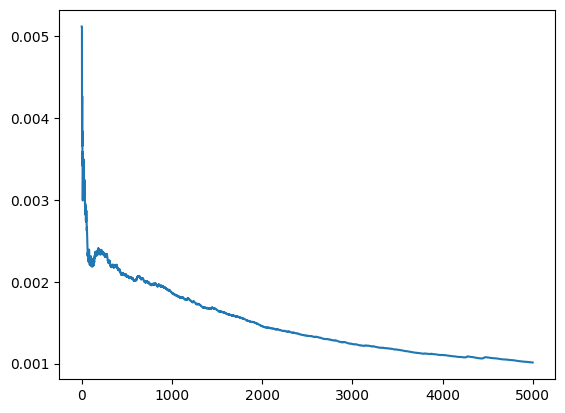

In [9]:
N = 5000
r_list_q,r_sum_list_q,r_sum_avg_list_q,local_actions_q = Server_Q_learning(N)
plt.plot(-r_sum_avg_list_q)
